In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("/content/BBC_News_processed[1].csv")
df.head()
print(df.columns)

Index(['Unnamed: 0', 'ArticleId', 'Text', 'Category', 'News_length',
       'Text_parsed', 'Category_target'],
      dtype='object')


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)


In [8]:
df['Clean_Text'] = df['Text'].apply(clean_text)

In [44]:
print("Unique custom categories:", df['custom_category'].unique())
print("Total count:", df['custom_category'].nunique())


Unique custom categories: ['economics' 'education' 'politics' 'sports' 'entertainment']
Total count: 5


In [45]:
df['custom_category'] = df['Category']



In [46]:
print(df['Category'].unique())

['economics' 'education' 'politics' 'sports' 'entertainment']


In [47]:
print(df['Category'].unique())
print(df['Category'].value_counts())


['economics' 'education' 'politics' 'sports' 'entertainment']
Category
sports           346
economics        336
politics         274
entertainment    273
education        261
Name: count, dtype: int64


In [48]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [49]:
class MarkovChain:
    def __init__(self):
        self.transitions = {}

    def train(self, texts):
        for text in texts:
            words = text.split()
            for i in range(len(words)-1):
                self.transitions.setdefault(words[i], []).append(words[i+1])

    def generate(self, word, length=50):
        output = [word]
        for _ in range(length-1):
            next_words = self.transitions.get(output[-1], [])
            if not next_words:
                break
            output.append(random.choice(next_words))
        return ' '.join(output)



In [50]:
df['custom_category'] = df['Category'].map(custom_mapping).fillna('other')




In [51]:
models = {}
for category in train_df['custom_category'].unique():
    texts = train_df.loc[train_df['custom_category']==category, 'Clean_Text'].tolist()
    model = MarkovChain()
    model.train(texts)
    models[category] = model

In [52]:
print("Models trained:", list(models.keys()))

Models trained: ['sports', 'economics', 'politics', 'entertainment', 'education']


In [53]:
def predict_custom_category(text, models):
    words = text.lower().split()
    best_category = None
    best_score = float('-inf')
    for category, model in models.items():
        score = 0
        for i in range(len(words)-1):
            next_words = model.transitions.get(words[i], [])
            if words[i+1] in next_words:
                score += 1  # increment score if this transition exists
            else:
                score -= 0.1  # slight penalty if transition doesn't exist
        if score > best_score:
            best_score = score
            best_category = category
    return best_category




In [54]:
# Test it
test_text = "The central bank announced new policies to boost economic growth."
predicted = predict_custom_category(test_text, models)
print("Predicted Category:", predicted)

Predicted Category: economics


In [55]:
# Apply prediction function with models passed in
test_df['predicted'] = test_df['Clean_Text'].apply(lambda x: predict_custom_category(x, models))

# Evaluate accuracy
accuracy = (test_df['custom_category'] == test_df['predicted']).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9563758389261745


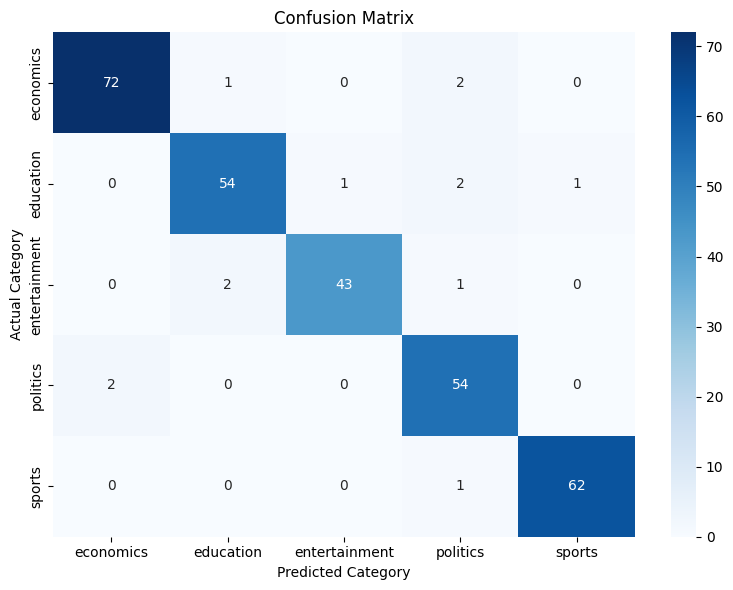

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the category list if not already defined
custom_categories = sorted(test_df['custom_category'].unique())

# Generate confusion matrix
cm = confusion_matrix(test_df['custom_category'], test_df['predicted'], labels=custom_categories)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=custom_categories, yticklabels=custom_categories, cmap="Blues")
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [57]:
print(classification_report(test_df['custom_category'], test_df['predicted']))

               precision    recall  f1-score   support

    economics       0.97      0.96      0.97        75
    education       0.95      0.93      0.94        58
entertainment       0.98      0.93      0.96        46
     politics       0.90      0.96      0.93        56
       sports       0.98      0.98      0.98        63

     accuracy                           0.96       298
    macro avg       0.96      0.95      0.96       298
 weighted avg       0.96      0.96      0.96       298

